# Active Learning Manager - Testing Notebook

This notebook demonstrates how to use the Manager class to run multiple AL experiments in parallel.

In [1]:
from pathlib import Path
from core.active_learner import Manager
import json

core.active_learner - INFO - Pre-warming UMAP (triggering numba JIT compilation)...
core.active_learner - INFO - UMAP pre-warming completed in 6.811095476150513


## 1. Initialize Manager

Load experiments from the config file.

In [ ]:
config_path = Path("core/config.yml")

manager = Manager(config_path)

print(f"Loaded {len(manager.experiments)} experiments:")
for name in manager.experiment_names:
    print(f"  - {name}")

core.active_learner - INFO - Loaded 1 experiment configurations from core\config.yml
core.active_learner - INFO - Initializing experiment: low_lr_experiment
ACTIVE LEARNER INIT CALLED
Loading annotations from: results\test_data\evaluations\birdnet\classification\default_classifier_annotations.csv
Loaded 4000 annotations


core\config.yml
[{'name': 'low_lr_experiment', 'embeddings_dir': WindowsPath('results/test_data/embeddings/2025-11-13_21-42___birdnet-test_data/audio/esc50'), 'annotations_path': WindowsPath('results/test_data/evaluations/birdnet/classification/default_classifier_annotations.csv'), 'model_name': 'birdnet', 'dataset_name': 'esc50', 'hidden_dim': None, 'learning_rate': 0.0001, 'device': 'cpu'}]


core.active_learner - INFO - Loaded 4000 embeddings with shape (4000, 1024)
core.active_learner - INFO - Initialized ActiveLearner with 4000 samples and 50 classes
core.active_learner - INFO - Manager initialized with 1 experiments


Loaded 1 experiments:
  - low_lr_experiment


## 2. View Initial Summary

In [3]:
summary = manager.get_summary()

for exp in summary['experiments']:
    print(f"{exp['name']}:")
    print(f"  Learning Rate: {exp['learning_rate']}")
    print(f"  Model: {exp['model_name']}")
    print(f"  Labeled: {exp['n_labeled']}, Unlabeled: {exp['n_unlabeled']}")
    print()

low_lr_experiment:
  Learning Rate: 0.0001
  Model: birdnet
  Labeled: 0, Unlabeled: 4000



## 3. Run a Single AL Cycle

Run one active learning cycle across all experiments.

In [4]:
# Run one AL cycle
results = manager.run(
    n_samples=10,        # Select 10 samples per experiment
    epochs=5,            # Train for 5 epochs
    batch_size=8,        # Batch size of 8
    parallel=False       # Run sequentially (set to True for parallel)
)

# Display results
for exp_name, metrics in results.items():
    print(f"{exp_name}:")
    print(f"  Loss: {metrics['loss']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Labeled: {metrics['n_labeled']}, Unlabeled: {metrics['n_unlabeled']}")
    print()

core.active_learner - INFO - Starting AL cycle: 10 samples, 5 epochs, parallel=False
core.active_learner - INFO - Added 10 samples. Labeled: 10, Unlabeled: 3990
core.active_learner - INFO - Training step complete: Loss=0.3660, Accuracy=0.0450
core.active_learner - INFO - Experiment 'low_lr_experiment' completed: {'loss': 0.3659630298614502, 'accuracy': 0.045, 'n_labeled': 10, 'n_unlabeled': 3990}


low_lr_experiment:
  Loss: 0.3660
  Accuracy: 0.0450
  Labeled: 10, Unlabeled: 3990



## 4. Run Multiple AL Cycles

Run multiple cycles to see how the experiments progress.

In [5]:
num_cycles = 3

for cycle in range(1, num_cycles + 1):
    print(f"\n{'='*60}")
    print(f"Cycle {cycle}/{num_cycles}")
    print('='*60)
    
    results = manager.run(
        n_samples=10,
        epochs=5,
        batch_size=8,
        parallel=False
    )
    
    for exp_name, metrics in results.items():
        print(f"{exp_name}: Loss={metrics['loss']:.4f}, Acc={metrics['accuracy']:.4f}")

core.active_learner - INFO - Starting AL cycle: 10 samples, 5 epochs, parallel=False
core.active_learner - INFO - Added 10 samples. Labeled: 20, Unlabeled: 3980
core.active_learner - INFO - Training step complete: Loss=0.1126, Accuracy=0.0752



Cycle 1/3


core.active_learner - INFO - Experiment 'low_lr_experiment' completed: {'loss': 0.11259880065917968, 'accuracy': 0.07525, 'n_labeled': 20, 'n_unlabeled': 3980}
core.active_learner - INFO - Starting AL cycle: 10 samples, 5 epochs, parallel=False
core.active_learner - INFO - Added 10 samples. Labeled: 30, Unlabeled: 3970
core.active_learner - INFO - Training step complete: Loss=0.0518, Accuracy=0.1087


low_lr_experiment: Loss=0.1126, Acc=0.0752

Cycle 2/3


core.active_learner - INFO - Experiment 'low_lr_experiment' completed: {'loss': 0.05176267557673984, 'accuracy': 0.10875, 'n_labeled': 30, 'n_unlabeled': 3970}
core.active_learner - INFO - Starting AL cycle: 10 samples, 5 epochs, parallel=False
core.active_learner - INFO - Added 10 samples. Labeled: 40, Unlabeled: 3960


low_lr_experiment: Loss=0.0518, Acc=0.1087

Cycle 3/3


core.active_learner - INFO - Training step complete: Loss=0.0213, Accuracy=0.1495
core.active_learner - INFO - Experiment 'low_lr_experiment' completed: {'loss': 0.021325448304414747, 'accuracy': 0.1495, 'n_labeled': 40, 'n_unlabeled': 3960}


low_lr_experiment: Loss=0.0213, Acc=0.1495


## 5. View Final Summary

In [6]:
final_summary = manager.get_summary()

for exp in final_summary['experiments']:
    print(f"{exp['name']}:")
    print(f"  Learning Rate: {exp['learning_rate']}")
    print(f"  Final Accuracy: {exp['current_accuracy']:.4f}")
    print(f"  Total Iterations: {exp['num_iterations']}")
    print(f"  Final Labeled: {exp['n_labeled']}, Unlabeled: {exp['n_unlabeled']}")
    print()

low_lr_experiment:
  Learning Rate: 0.0001
  Final Accuracy: 0.1495
  Total Iterations: 4
  Final Labeled: 40, Unlabeled: 3960



## 6. Compare Training Histories

Plot the training histories to compare experiments.

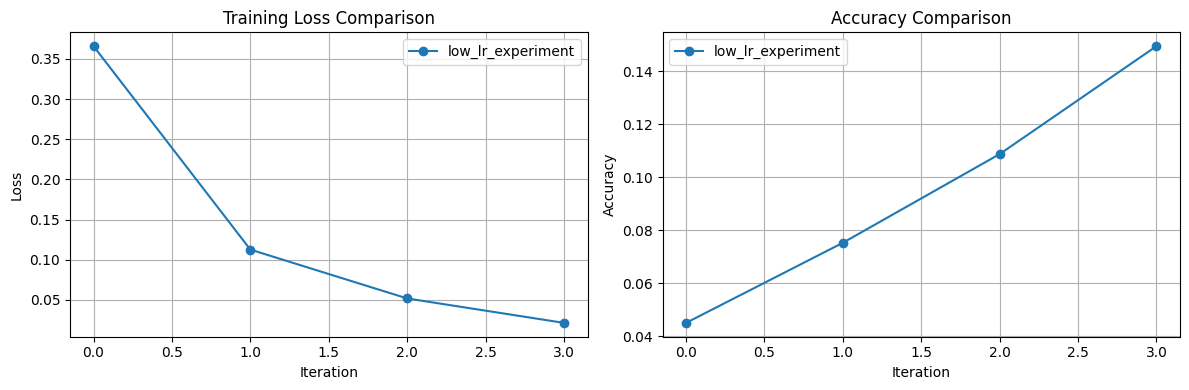

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
for learner, name in zip(manager.experiments, manager.experiment_names):
    losses = [h['loss'] for h in learner.training_history]
    plt.plot(losses, marker='o', label=name)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
for learner, name in zip(manager.experiments, manager.experiment_names):
    accuracies = [h['accuracy'] for h in learner.training_history]
    plt.plot(accuracies, marker='o', label=name)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Save Results

Save all experiment results to JSON files.

In [8]:
output_dir = Path("results/manager_test")
manager.save(output_dir=output_dir)
print(f"Results saved to: {output_dir}")

core.active_learner - INFO - Saved results for 'low_lr_experiment' to results\manager_test\low_lr_experiment_20251116_103324.json
core.active_learner - INFO - Saved experiment summary to results\manager_test\summary_20251116_103324.json


Results saved to: results\manager_test


## 8. (Optional) Add a New Experiment Dynamically

In [9]:
# Example: Add a new experiment with a different learning rate
new_config = {
    'embeddings_dir': 'results/test_data/embeddings/2025-11-13_21-42___birdnet-test_data/audio/esc50',
    'annotations_path': 'results/test_data/evaluations/birdnet/classification/default_classifier_annotations.csv',
    'model_name': 'birdnet',
    'dataset_name': 'esc50',
    'learning_rate': 0.0005,  # Medium learning rate
    'device': 'cpu'
}

manager.add(new_config, name='medium_lr_experiment')
print(f"Added new experiment. Total experiments: {len(manager.experiments)}")

core.active_learner - INFO - Adding new experiment: medium_lr_experiment
ACTIVE LEARNER INIT CALLED
Loading annotations from: results\test_data\evaluations\birdnet\classification\default_classifier_annotations.csv
Loaded 4000 annotations
core.active_learner - INFO - Loaded 4000 embeddings with shape (4000, 1024)
core.active_learner - INFO - Initialized ActiveLearner with 4000 samples and 50 classes


Added new experiment. Total experiments: 2


## 9. Test Parallel Execution

Run experiments in parallel for faster execution.

In [10]:
import time

# Sequential
start = time.time()
results_seq = manager.run(n_samples=5, epochs=3, batch_size=8, parallel=False)
sequential_time = time.time() - start

# Parallel
start = time.time()
results_par = manager.run(n_samples=5, epochs=3, batch_size=8, parallel=True)
parallel_time = time.time() - start

print(f"Sequential time: {sequential_time:.2f}s")
print(f"Parallel time: {parallel_time:.2f}s")
print(f"Speedup: {sequential_time/parallel_time:.2f}x")

core.active_learner - INFO - Starting AL cycle: 5 samples, 3 epochs, parallel=False
core.active_learner - INFO - Added 5 samples. Labeled: 45, Unlabeled: 3955
core.active_learner - INFO - Training step complete: Loss=0.0192, Accuracy=0.1693
core.active_learner - INFO - Experiment 'low_lr_experiment' completed: {'loss': 0.01916785173945957, 'accuracy': 0.16925, 'n_labeled': 45, 'n_unlabeled': 3955}
core.active_learner - INFO - Added 5 samples. Labeled: 5, Unlabeled: 3995
core.active_learner - INFO - Training step complete: Loss=0.0413, Accuracy=0.0640
core.active_learner - INFO - Experiment 'medium_lr_experiment' completed: {'loss': 0.041336044669151306, 'accuracy': 0.064, 'n_labeled': 5, 'n_unlabeled': 3995}
core.active_learner - INFO - Starting AL cycle: 5 samples, 3 epochs, parallel=True
core.active_learner - INFO - Added 5 samples. Labeled: 50, Unlabeled: 3950
core.active_learner - INFO - Added 5 samples. Labeled: 10, Unlabeled: 3990
core.active_learner - INFO - Training step comple

Sequential time: 0.23s
Parallel time: 0.28s
Speedup: 0.81x
